<a href="https://colab.research.google.com/github/lmquann/leminhquan/blob/main/B%E1%BA%A3n_sao_c%E1%BB%A7a_NLP_SOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install datasets
!pip install torch torchvision torchaudio
!pip install underthesea
!pip install tensorflow

In [ ]:
import pandas as pd
df = pd.read_excel('/content/data_nlp500.xlsx')

df.head(3)

,Sentence,agreement,annotation_id,annotator,created_at,history,id,label,lead_time,updated_at
0,Ăn tôm với cam có dễ gây ngộ độc asen không nhỉ?,100,58497878,69467,2025-04-10 14:36:18.775,"[{""id"":63798146,""comment"":null,""organization_i...",167131458,"[{""end"":6,""text"":""tôm"",""start"":3,""labels"":[""fo...",152.338,2025-04-10 14:36:18.775
1,Gan lợn và giá đỗ ăn chung có vấn đề gì không ...,100,58497918,69467,2025-04-10 14:36:54.680,"[{""id"":63755968,""comment"":null,""organization_i...",167131459,"[{""end"":7,""text"":""Gan lợn"",""start"":0,""labels"":...",22.926,2025-04-10 14:36:54.680
2,Mình có nên ăn cà chua và dưa chuột cùng lúc k...,100,58535061,69670,2025-04-10 22:05:36.201,"[{""id"":63798152,""comment"":null,""organization_i...",167131460,"[{""end"":22,""text"":""cà chua"",""start"":15,""labels...",15.090,2025-04-10 22:05:36.201


In [ ]:
# Khám phá dữ liệu
print(df.info())
print(df['label'].value_counts())

# Độ dài câu
df['sentence_length'] = df['Sentence'].apply(lambda x: len(x.split()))
print(df['sentence_length'].describe())

# Kiểm tra các thực thể "food" duy nhất
unique_foods = set()
for labels in df['label']:
    for item in eval(labels):
        unique_foods.add(item['text'])
print("Các thực thể 'food' duy nhất:", unique_foods)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Sentence       422 non-null    object        
 1   agreement      422 non-null    int64         
 2   annotation_id  422 non-null    int64         
 3   annotator      422 non-null    int64         
 4   created_at     422 non-null    datetime64[ns]
 5   history        422 non-null    object        
 6   id             422 non-null    int64         
 7   label          422 non-null    object        
 8   lead_time      422 non-null    float64       
 9   updated_at     422 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 33.1+ KB
None
label
[{"end":23,"text":"cà phê","start":17,"labels":["food"]},{"end":33,"text":"cam","start":30,"labels":["food"]}]              2
[{"end":11,"text":"sữa tươi","start":3,"labels":["food"]},{"end"

In [ ]:
#LÀM SẠCH DỮ LIỆU
# Xử lý giá trị thiếu
df.dropna(subset=['Sentence', 'label'], inplace=True)

# Làm sạch dữ liệu văn bản
def clean_text(text):
    text = text.lower()  # Chuyển thành chữ thường
    text = ''.join(e for e in text if e.isalnum() or e.isspace())  # Loại bỏ ký tự không cần thiết
    return text

df['Sentence'] = df['Sentence'].apply(clean_text)
print("Dữ liệu đã được làm sạch.")

Dữ liệu đã được làm sạch.


In [ ]:
# CHUẨN BỊ DỮ LIỆU
from sklearn.model_selection import train_test_split
# from transformers import BertTokenizer
import numpy as np
import pandas as pd

# Chuyển đổi nhãn thành định dạng BIO
def convert_labels_to_bio(sentences, labels):
    bio_labels = []
    for sentence, label in zip(sentences, labels):
        words = sentence.split()
        bio = ['O'] * len(words)  # Gán nhãn O cho tất cả
        for item in eval(label):
            start = item['start']
            end = item['end']
            text = item['text']
            word_indices = [i for i, word in enumerate(words) if word in text]

            for idx in word_indices:
                if idx == word_indices[0]:
                    bio[idx] = 'B-food'  # Nhãn B cho từ đầu tiên của thực thể
                else:
                    bio[idx] = 'I-food'  # Nhãn I cho các từ tiếp theo

        bio_labels.append(bio)
    return bio_labels

# Chuyển đổi nhãn
bio_labels = convert_labels_to_bio(df['Sentence'], df['label'])

# Chia dữ liệu thành tập huấn luyện, kiểm chứng và kiểm thử
X_train, X_test, y_train, y_test = train_test_split(df['Sentence'], bio_labels, test_size=0.2, random_state=42)


CHẠY VỚI DATA THIỆT THÌ TĂNG EPOCH LÊN

In [ ]:
#mới phobert
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model # Import Model
from tensorflow.keras.layers import Dense, Dropout, TimeDistributed, Bidirectional, LSTM, Input # Import Input

# Độ dài tối đa cho câu
max_length = 50  # Bạn có thể điều chỉnh độ dài tối đa này

# Tải tokenizer và mô hình PhoBERT
tokenizer = BertTokenizer.from_pretrained('vinai/phobert-base')
bert_model = TFBertModel.from_pretrained('vinai/phobert-base')

# Chuyển đổi văn bản thành ID
def encode_sentences(sentences):
    input_ids = []
    attention_masks = []
    for sentence in sentences:
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length, # Use the defined max_length
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)


# Chuyển đổi dữ liệu
X_train_ids, X_train_masks = encode_sentences(X_train)
X_test_ids, X_test_masks = encode_sentences(X_test)


# Tạo từ điển cho nhãn
unique_labels = set(label for sublist in y_train for label in sublist)
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

# Chuyển đổi nhãn thành ID
def encode_labels(labels, max_length):
    encoded_labels = []
    for label in labels:
        encoded = [label2id[l] for l in label]
        # Gán nhãn 0 cho các vị trí không có thực thể
        encoded += [0] * (max_length - len(encoded))
        encoded_labels.append(encoded[:max_length])  # Cắt hoặc thêm nhãn cho đủ độ dài
    return np.array(encoded_labels)



y_train_ids = encode_labels(y_train, max_length)
y_test_ids = encode_labels(y_test, max_length)

# Tạo mô hình với PhoBERT
# Thay đổi ở đây: Sử dụng tf.keras.Input thay vì tf.keras.layers.Input
input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids') # Changed from tf.keras.layers.Input to Input
attention_masks = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask') # Changed from tf.keras.layers.Input to Input

# Tạo một lớp tùy chỉnh để bao bọc bert_model
# class BertLayer(tf.keras.layers.Layer):
#     def __init__(self, bert_model, **kwargs):
#         super(BertLayer, self).__init__(**kwargs)
#         self.bert_model = bert_model

#     def call(self, inputs):
#         input_ids, attention_mask = inputs
#         bert_output = self.bert_model(input_ids, attention_mask=attention_mask)[0]  # Get the first output (sequence_output)
#         return bert_output

class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask)[0]  # Get the first output (sequence_output)
        return bert_output

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'bert_model': self.bert_model.name # Store the name of the bert_model
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Load the Bert model from the stored name
        bert_model = TFBertModel.from_pretrained(config['bert_model'])
        return cls(bert_model) # Create and return a new BertLayer instance


# Sử dụng lớp BertLayer trong mô hình
bert_layer = BertLayer(bert_model)
sequence_output = bert_layer([input_ids, attention_masks])


# Thêm các lớp LSTM
x = Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.1))(sequence_output)
x = Dropout(0.5)(x)  # Thêm Dropout để giảm overfitting
x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.1))(x)

# Thêm lớp Dense
output = TimeDistributed(Dense(len(unique_labels), activation='softmax'))(x)

# Tạo mô hình
model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output)

# Biên dịch mô hình
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(
    [X_train_ids, X_train_masks],
    y_train_ids,
    batch_size=32,
    epochs=1,
    validation_split=0.1,
    verbose=1
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PhobertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFBertModel: ['lm_head', 'roberta']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequ

10/10 ━━━━━━━━━━━━━━━━━━━━ 107s 7s/step - accuracy: 0.6974 - loss: 0.5765 - val_accuracy: 0.9265 - val_loss: 0.2277


In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer_2 (BertLayer)  │ (None, 50, 768)        │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 50, 256)        │        918,528 │ bert_layer_2[0][0]     │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 50, 256)        │              0 │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 50, 128)        │        164,352 │ dropout_2[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, 50, 3)          │            387 │ bidirectional_5[0][0]  │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,249,803 (12.40 MB)

 Trainable params: 1,083,267 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,166,536 (8.26 MB)

In [ ]:
# Lưu model
from tensorflow import keras
model.save('food_ner_model.keras')


# # When loading the model:
# with custom_object_scope({'BertLayer': BertLayer}):  # Use custom_object_scope
#     loaded_model = keras.models.load_model('food_ner_model.keras')

In [ ]:
print("id2label dictionary:", id2label)
print("Unique predicted labels:", np.unique(y_pred_labels))

id2label dictionary: {0: 'I-food', 1: 'B-food', 2: 'O'}
Unique predicted labels: [0 1 2]


In [ ]:
# Dự đoán trên tập kiểm thử
y_pred = model.predict([X_test_ids, X_test_masks]) # Provide both input_ids and attention_masks
y_pred_labels = np.argmax(y_pred, axis=-1)

# Chuyển đổi nhãn dự đoán về định dạng văn bản
def decode_predictions(predictions, id2label):
    decoded = []
    for pred in predictions:
        # decoded.append([id2label[label] for label in pred if label != 0])  # Bỏ qua nhãn 0
        decoded.append([id2label[label] for label in pred])

    return decoded

y_pred_decoded = decode_predictions(y_pred_labels, id2label)
y_pred_decoded

3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step


[['O',
  'O',
  'O',
  'O',
  'B-food',
  'I-food',
  'O',
  'B-food',
  'O',
  'O',
  'O',
  'O',
  'O',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food'],
 ['O',
  'O',
  'O',
  'O',
  'B-food',
  'I-food',
  'O',
  'B-food',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',
  'I-food',


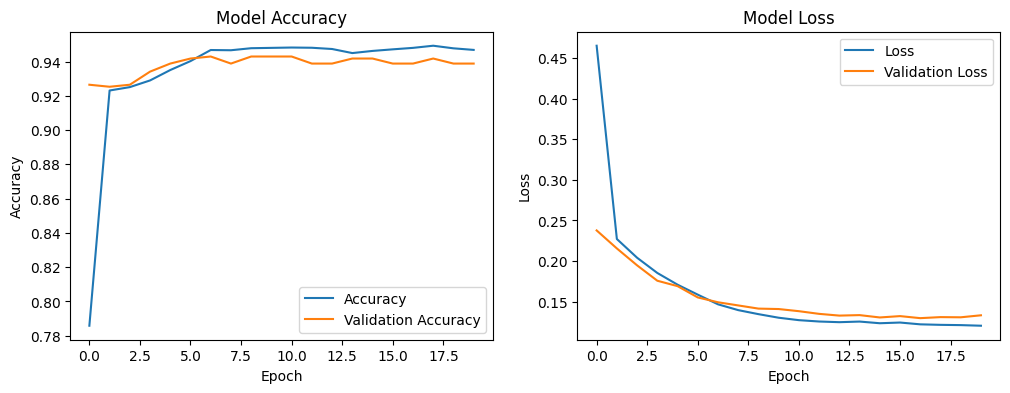

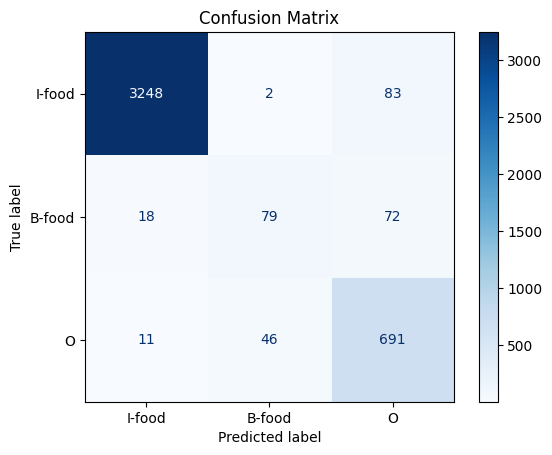

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Trực quan hóa độ chính xác và mất mát
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Ma trận nhầm lẫn
# Ensure both arrays have the same length before creating confusion matrix
min_length = min(y_test_ids.flatten().shape[0], y_pred_labels.flatten().shape[0])
cm = confusion_matrix(y_test_ids.flatten()[:min_length], y_pred_labels.flatten()[:min_length])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2label[i] for i in range(len(id2label))])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Chuyển đổi y_test thành định dạng nhị phân
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report # Import classification_report

mlb = MultiLabelBinarizer()
y_test_binary = mlb.fit_transform(y_test)
y_pred_binary = mlb.transform(y_pred_decoded)

# Tạo báo cáo phân loại sử dụng định dạng nhị phân
report_binary = classification_report(y_test_binary, y_pred_binary, output_dict=True)
report_binary_df = pd.DataFrame(report_binary).transpose()
print(report_binary_df)

              precision  recall  f1-score  support
0              1.000000     1.0  1.000000     85.0
1              0.952941     1.0  0.975904     81.0
2              1.000000     1.0  1.000000     85.0
micro avg      0.984314     1.0  0.992095    251.0
macro avg      0.984314     1.0  0.991968    251.0
weighted avg   0.984814     1.0  0.992224    251.0
samples avg    0.984314     1.0  0.990588    251.0


In [ ]:
import nltk

# Download the 'punkt_tab' data
nltk.download('punkt_tab')

# Hướng dẫn sử dụng mô hình đã huấn luyện
def predict_entities(sentence):
    # Mã hóa câu nhập vào
    encoded_sentence = encode_sentences([sentence])

    # Dự đoán nhãn cho câu
    predictions = model.predict(encoded_sentence)

    # Lấy nhãn dự đoán với giá trị lớn nhất
    predicted_labels = np.argmax(predictions, axis=-1)[0]  # Lấy dự đoán cho câu đầu tiên

    # Giải mã nhãn dự đoán
    decoded_labels = [id2label[label] for label in predicted_labels]

    # Use the same tokenizer used during training
    tokens = nltk.word_tokenize(sentence)

    # Align the tokens and labels based on the training tokenizer
    food_entities = []
    for idx, label in enumerate(decoded_labels[:len(tokens)]):  # Ensure idx is within bounds
        if label == 'B-food' or label == 'I-food':
            food_entities.append(tokens[idx])

    # Hiển thị kết quả
    if food_entities:
        print(f"Nhập câu: {sentence}")
        print(f"Thực phẩm được nhận diện: {', '.join(food_entities)}\n")
    else:
        print(f"Nhập câu: {sentence}")
        print("Không có thực phẩm nào được nhận diện.\n")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Ví dụ dự đoán
example_sentence = ("tôi có thể ăn cà chua với là sữa không?")
predict_entities(example_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
Nhập câu: tôi có thể ăn cà chua với là sữa không?
Thực phẩm được nhận diện: cà, chua



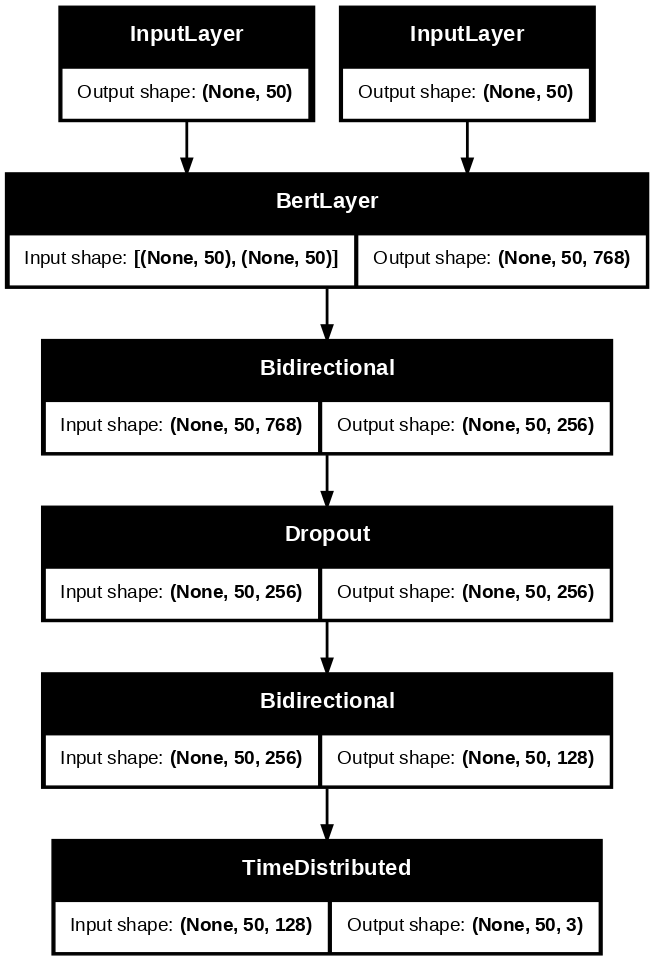

In [ ]:
from tensorflow.keras.utils import plot_model # Import the plot_model function
plot_model(model, 'model.png', show_shapes=True, dpi=100) # Call the function after importing

In [ ]:
# Tổng kết
print("Tổng kết dự án NER:")
print("1. Tiền xử lý: Làm sạch dữ liệu, chuyển đổi nhãn thành định dạng BIO.")
print("2. Kiến trúc mô hình: Sử dụng LSTM/BiLSTM với embedding từ PhoBERT.")
print("3. Huấn luyện: Huấn luyện mô hình với Adam optimizer và sparse categorical crossentropy.")
print("4. Đánh giá: Sử dụng precision, recall, F1-score và accuracy để đánh giá mô hình.")
print("5. Trực quan hóa: Đường cong học, ma trận nhầm lẫn.")